# Training Efficiency Analysis

This notebook analyzes training efficiency by plotting success rate vs total steps:
- Downloads training history from training runs (Episode/success_rate)
- Plots mean success rate with 95% CI shaded region
- Optionally shows threshold line and labels steps to reach it

In [9]:
# ============================================================
# BLOCK 1: IMPORTS & LOCAL CONFIGURATION
# ============================================================

import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import shared utilities
from analysis_utils import (
    # Constants
    ENTITY, PROJECT, COLORS,
    # Data functions
    download_training_history,
    # Plotting functions
    plot_training_curves,
)

# ============================================================
# LOCAL CONFIGURATION (specific to this analysis)
# ============================================================

# Method Tags
METHOD_TAGS = {
    #"Pose": "pose_perf-comp:2026-01-05_10:54",
    #"Hybrid-Basic": "basic-hybrid_perf-comp:2026-01-05_10:54",
    #"SWISH": "LCLoP_fix_perf-comp:2026-01-09_11:17",
    #"Pose": "pose_base-case:2026-02-02_13:40",
    #"MATCH": "MATCH_base-case:2026-02-04_17:46",
    #"Hybrid-Basic": "basic-hybrid_base-case:2026-02-02_13:40",


    "Pose(1mm)": "pose_breakable_f10N:2026-02-04_17:49",
    #"Pose(2.5mm)": "pose_25mm_f10:2026-02-05_22:12",
    "MATCH(1mm)": "MATCH_breakable_10N:2026-02-04_17:49",
    "Hybrid-Basic(1mm)": "basic-hybrid_breakable_f10N:2026-02-04_17:49",
}

# Metric to extract from training runs
METRIC_COL = "Episode/success_rate"
SCALE_FACTOR = 100.0  # Convert from 0-1 to percentage

# Threshold Configuration
SUCCESS_THRESHOLD = 80  # Percentage threshold for labeling
SHOW_THRESHOLD_ANNOTATIONS = False  # Set to True to show threshold line and annotations

# Plot Configuration
X_LIM = (0, 2500000)
Y_LIM = (0, 100)
Y_TICKS = [0, 20, 40, 60, 80, 100]
CI_ALPHA = 0.2

In [10]:
# ============================================================
# BLOCK 2: DOWNLOAD TRAINING DATA
# ============================================================

api = wandb.Api()
training_data = {}

print("Downloading training history...")
print("=" * 60)

for method_name, method_tag in METHOD_TAGS.items():
    print(f"\n{method_name} ({method_tag}):")
    training_data[method_name] = download_training_history(
        api=api,
        method_tag=method_tag,
        metric_col=METRIC_COL,
        scale_factor=SCALE_FACTOR,
    )

# Print summary
print("\n" + "=" * 60)
print("DATA SUMMARY")
print("=" * 60)
for method_name, df in training_data.items():
    if not df.empty:
        n_runs = df["run_name"].nunique()
        n_steps = df["total_steps"].nunique()
        print(f"{method_name}: {n_runs} runs, {n_steps} unique steps")
    else:
        print(f"{method_name}: No data")


Pose(1mm) (pose_breakable_f10N:2026-02-04_17:49):
  pose_breakable_f(10)_0: 65 checkpoints
  pose_breakable_f(10)_2: 65 checkpoints
  pose_breakable_f(10)_1: 65 checkpoints
  pose_breakable_f(10)_3: 65 checkpoints
  pose_breakable_f(10)_4: 65 checkpoints
  Eval_noise_best_pose_breakable_f(10)_0: 1 checkpoints
  Eval_noise_best_pose_breakable_f(10)_2: 1 checkpoints
  Eval_noise_best_pose_breakable_f(10)_1: 1 checkpoints
  Eval_noise_best_pose_breakable_f(10)_3: 1 checkpoints
  Eval_noise_best_pose_breakable_f(10)_4: 1 checkpoints
  Eval_forge_noise_best_pose_breakable_f(10)_0: 1 checkpoints
  Eval_forge_noise_best_pose_breakable_f(10)_2: 1 checkpoints
  Eval_forge_noise_best_pose_breakable_f(10)_1: 1 checkpoints
  Eval_forge_noise_best_pose_breakable_f(10)_3: 1 checkpoints
  Eval_forge_noise_best_pose_breakable_f(10)_4: 1 checkpoints

MATCH(1mm) (MATCH_breakable_10N:2026-02-04_17:49):
  MATCH_breakable_f(10)_0: 64 checkpoints
  MATCH_breakable_f(10)_2: 64 checkpoints
  MATCH_breakable_

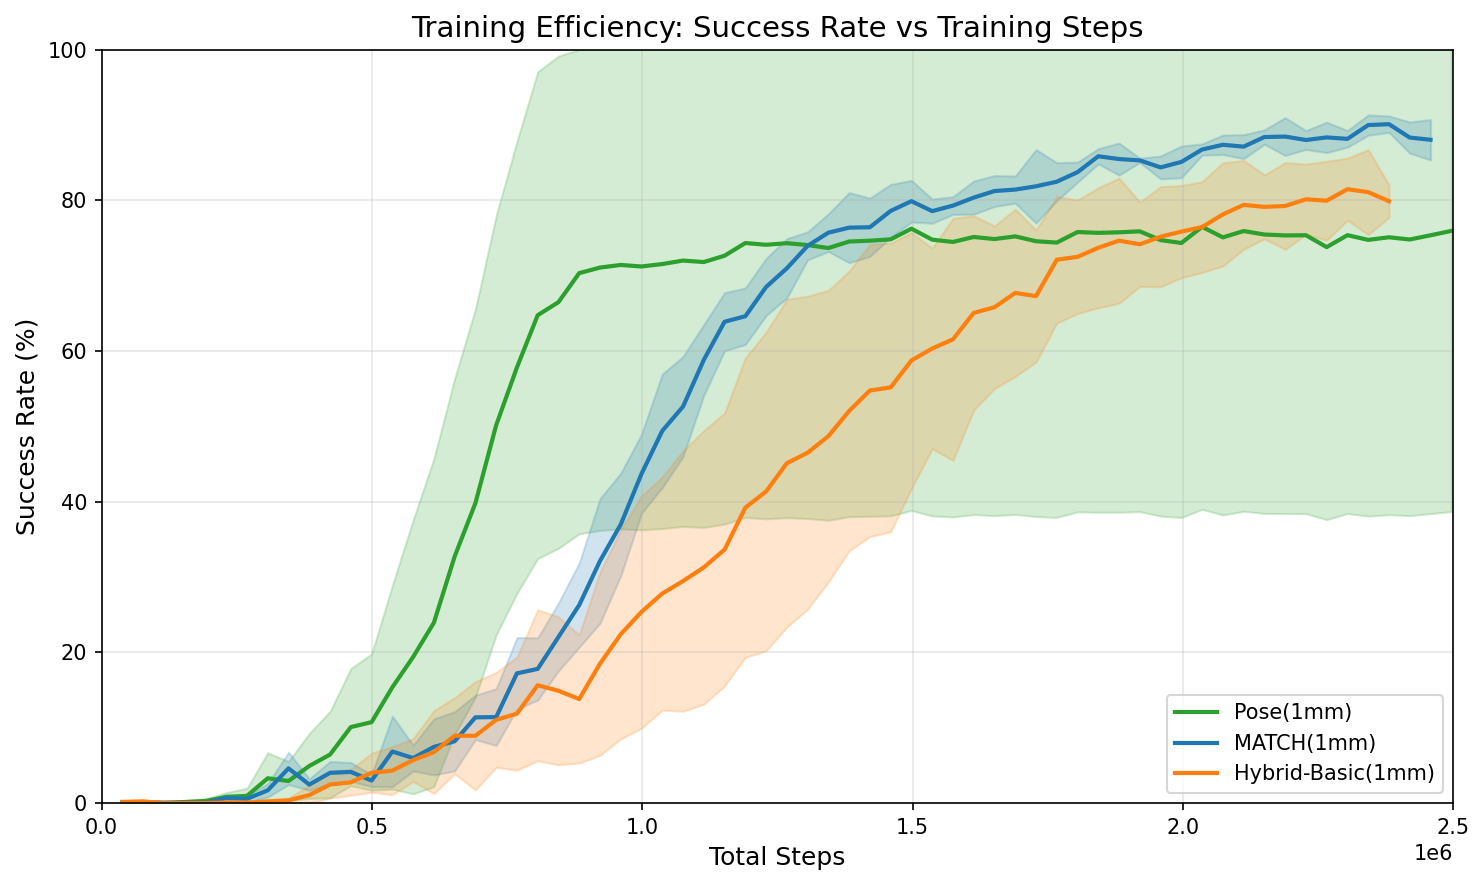

In [11]:
# ============================================================
# BLOCK 3: TRAINING EFFICIENCY PLOT
# ============================================================

fig, ax, threshold_crossings = plot_training_curves(
    data_by_method=training_data,
    title="Training Efficiency: Success Rate vs Training Steps",
    x_label="Total Steps",
    y_label="Success Rate (%)",
    x_lim=X_LIM,
    y_lim=Y_LIM,
    y_ticks=Y_TICKS,
    threshold=SUCCESS_THRESHOLD if SHOW_THRESHOLD_ANNOTATIONS else None,
    show_threshold_annotations=SHOW_THRESHOLD_ANNOTATIONS,
    ci_alpha=CI_ALPHA,
)

# Print threshold crossings if computed
if threshold_crossings:
    print("\n" + "=" * 60)
    print(f"STEPS TO REACH {SUCCESS_THRESHOLD}% SUCCESS RATE")
    print("=" * 60)
    for method_name, step in sorted(threshold_crossings.items(), key=lambda x: x[1]):
        print(f"{method_name}: {step:,} steps")

plt.show()